# Data Science Lab Project SS24
# APA-IT Informations Technologie GmbH
# News article classification
## Team members:
- Nurzhanat Zhussup
- Mariia
- Gregor
- Danylo

### Data import and preprcoessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
interview = pd.read_json('./export_20240314/interview.jsonl', lines=True)
letters = pd.read_json('./export_20240314/leserbrief.jsonl', lines=True)
comments = pd.read_json('./export_20240314/meinung.jsonl', lines=True)

#### In this part we will take the date that was labeled as relevant and concat all data into 1 df

In [4]:
data = [interview, letters, comments]

# Extract data from list values in "labels" column
for i in range(len(data)):
    data[i]['labels'] = data[i]['labels'].apply(lambda x: x[0])

interview = data[0]
letters = data[1]
comments = data[2]

In [5]:
for i, d in enumerate(data):
    print(f"Data {i}:\nUnique labels: {d['labels'].unique()}")

Data 0:
Unique labels: ['RELEVANT' 'NONRELEVANT']
Data 1:
Unique labels: ['RELEVANT' 'NONRELEVANT']
Data 2:
Unique labels: ['RELEVANT' 'NONRELEVANT']


In [6]:
# Filter the datasets to include only relevant data
for i in range(len(data)):
    data[i] = data[i][data[i]['labels'] == 'RELEVANT']

In [7]:
# Rewrite the label values in each dataset
for i in range(len(data)):
    if i == 0:
        data[i].loc[:, 'labels'] = 'interview'
    elif i == 1:
        data[i].loc[:, 'labels'] = 'letter'
    else:
        data[i].loc[:, 'labels'] = 'comment'

In [8]:
for i, d in enumerate(data):
    print(f"Data {i}:\nUnique labels: {d['labels'].unique()}")

Data 0:
Unique labels: ['interview']
Data 1:
Unique labels: ['letter']
Data 2:
Unique labels: ['comment']


In [9]:
# Concat data into 1 df
df = pd.concat(data, ignore_index=True)
df

,labels,text,unikey,recname,recstamp
0,interview,Zwei Jubiläen als Stresstest\n\ninterviewLento...,2.099312e+18,KRONE_2023123115001241154,2023-12-31T00:00:00Z
1,interview,"Leserbrief: ""Klimawandel oder Klimakrise""\n\n ...",6.326778e+18,KRONE_2023123115001241348,2023-12-31T00:00:00Z
2,interview,„Kaum eine Woche unter 80 Arbeitsstunden!“\n\n...,1.018152e+19,KRONE_2023123115001241763,2023-12-31T00:00:00Z
3,interview,„Check this out! This is paradise!“\n\nDer US-...,2.242322e+18,KRONE_2023123115001241958,2023-12-31T00:00:00Z
4,interview,„Es War eine extreme hochschaubahn“\n\n Der ...,1.969262e+18,KRONE_2023123115001240272,2023-12-31T00:00:00Z
...,...,...,...,...,...
6755,comment,Die Schulpolitik macht Ferien in Skandinavien\...,8.403356e+18,PRESSE_20230702000000059,2023-07-02T00:00:00Z
6756,comment,"Kreative Köpfe statt Normaldenker, frische Neu...",9.137500e+18,PRESSE_20230701000000151,2023-07-01T00:00:00Z
6757,comment,"Schilling, Daphne und Lire\n\n Daphne? Das w...",1.125905e+19,PRESSE_20230701000000142,2023-07-01T00:00:00Z
6758,comment,EU-Regierungen verlernen Demokratie\n\nGetroff...,6.232365e+18,PRESSE_20230701000000016,2023-07-01T00:00:00Z


### Text preprocessing

**In the letters most of the texts contain "Lesebrief" at the beginning. This would be the cheating if we input this in our model. Therefore in this part we are going to inspect our text data and remove such labels in the texts.**

In [10]:
words = ['leserpost', 'leserbrief']
labels = ['letter', 'comment', 'interview']
total = []

for label in labels:
    bool_results = []
    for val in df[df['labels'] == label]['text']:
        found = False
        for word in words:
            if word in val.lower():
                found = True
                break  # Exit the loop if any word is found
        bool_results.append(found)
        total.append(found)
    print(f"Results for {label}: ")
    print(f"{pd.Series(bool_results).value_counts()}\n")

print(f"Total results: \n{pd.Series(total).value_counts()}")

Results for letter: 
True     4047
False      63
Name: count, dtype: int64

Results for comment: 
False    662
True       3
Name: count, dtype: int64

Results for interview: 
False    1922
True       63
Name: count, dtype: int64

Total results: 
True     4113
False    2647
Name: count, dtype: int64


In [11]:
bool_results = []
for val in letters[letters['labels'] == 'NONRELEVANT']['text']:
    found = False
    for word in words:
        if word in val.lower():
            found = True
            break
    bool_results.append(found)
print(f"Results for NONRELEVANT data in letters:\n{pd.Series(bool_results).value_counts()}")

Results for NONRELEVANT data in letters:
False    166947
True        134
Name: count, dtype: int64


**The text sure needs to be preprocessed, because the majority of the predefined words are found in the labeled letters data but not found in unlabeled data. Therefore, in order to avoid cheating, we need to remove these words**

In [12]:
for i, val in enumerate(df[df['labels'] == 'letter']['text']):
    if i == 3:
        break
    print(f"Text number {i}")
    print(val)

Text number 0
Leserbrief: "Rechtsruck in Europa?"

   Fast schockiert berichten die Medien vom Rechtsruck der Politik
in Europa. Offenbar lässt es sich jetzt nicht mehr unter den Teppich
kehren, dass die Menschen von einer Politik genug haben, die sie
nicht mehr verstehen. Jahrzehntelang haben selbst ernannte
Besserwisser die Bevölkerung mit ihren teils abstrusen
Weltanschauungen in Geiselhaft genommen. Was ist daraus entstanden?
Zum Beispiel eine unkontrollierte Zuwanderung, die zum Untergang der
eigenen Kultur führen kann, eine Verhunzung der Sprache bis zur
Unkenntlichkeit, Schutz von Tätern und Alleinlassen von Opfern,
gezielte „Entbildung“ der Gesellschaft, eine gezielte Enteignung der
individuellen Eigenverantwortung und vieles mehr. Dafür hat
Korruption, Lobbyismus und Freunderlwirtschaft ein Ausmaß erreicht,
das zum Himmel stinkt.


   Bei all dem redet man sich oft auf einen Zwang hinaus, den man
sich selbst verordnet hat. Globalisierung und Multikulti können
letztlich auch nu

In [13]:
count = 0
for i, val in enumerate(df[df['labels'] == 'letter']['text']):
    if "leserpost" in val.lower():
        print(f"Text number {i}")
        print(val)
        count += 1
    if count == 1:
        break


Text number 3980
LESERPOST

Leserbriefe bitte an: Die Presse, Hainburger Straße 33, A-1030 Wien
oder an leserbriefe@diepresse.com

Zeitgemäße demokratische Prinzipien?

„Massive EU-Skepsis…?“, LB von Friederike Pacik, 11.12.Diesem
treffenden Leserbriefzur EU-Skepsis sei die Frage nachgereicht, wie
es den EU-Bürgern mit den gegenwärtigen Entscheidungsregeln etwa im
Förderwesen der Union geht. Immerhin zahlen alle Mitgliedsländer
erhebliche Summen in die Brüsseler Gemeinschaftskasse. Wenn dann bei
der Mittelverteilung laufend der Eindruck entsteht, dass große
Nettoempfänger sich unverblümt und trickreich auf Kosten aller
EU-Steuerzahler aus den Fördertöpfen bedienen, wird der wachsende
Unmut gegen das System auch aus dieser Sicht verständlich. Zur
Trickkiste zählt etwa die für wichtige Entscheidungen erforderliche
Einstimmigkeit als möglicher „Hebel zum Geld“. Mittlerweile ist es
weithin sichtbar, wie einfach es ist, große Vorhaben der Union auch
nur mit einer einzigen Gegenstimme zu blo

In [14]:
for label in labels:
    bool_results = []
    for val in df[df['labels'] == label]['text']:
        found = False
        if 'leserpost' in val.lower():
            found = True
        bool_results.append(found)
    print(f"Word 'Leserpost' in {label}: ")
    print(f"{pd.Series(bool_results).value_counts()}\n")

Word 'Leserpost' in letter: 
False    4021
True       89
Name: count, dtype: int64

Word 'Leserpost' in comment: 
False    665
Name: count, dtype: int64

Word 'Leserpost' in interview: 
False    1985
Name: count, dtype: int64



**The word "leserpost" appears rather rarely than "leserbrief". But it's only found in letter label, so it makes sense to remove these 2 words to avoid cheating.**

In [15]:
# Loop through each text at each row and replace the word with "" if the word i
for i in range(len(df)):
    text = df.at[i, 'text'].lower()
    for word in words:
        text = text.replace(word, '')
    df.at[i, 'text'] = text

In [16]:
for label in labels:
    bool_results = []
    for val in df[df['labels'] == label]['text']:
        found = False
        for word in words:
            if word in val.lower():
                found = True
                break
        bool_results.append(found)
        total.append(found)
    print(f"Results for {label}: ")
    print(f"{pd.Series(bool_results).value_counts()}\n")

Results for letter: 
False    4110
Name: count, dtype: int64

Results for comment: 
False    665
Name: count, dtype: int64

Results for interview: 
False    1985
Name: count, dtype: int64



### Modelling
#### In this section we will try 4 basic models. Then we will take the best performing models and fine tune them

Models in this section:
- Logistic Regression
- Random Forest
- Decision Tree Classifier
- Support Vector Classifier

In [174]:
ml_df = df[['text', 'labels']]
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6760 entries, 0 to 6759
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6760 non-null   object
 1   labels  6760 non-null   object
dtypes: object(2)
memory usage: 105.8+ KB


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ibragimzhussup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibragimzhussup/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
stop_words = set(stopwords.words('german'))
stemmer = SnowballStemmer("german")

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Tokenization and lowercasing
    words = word_tokenize(text.lower())
    # Removing stopwords and Stemming
    cleaned_words = [stemmer.stem(word) for word in words if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(cleaned_words)

In [61]:
ml_df.loc[:,'text'] = ml_df['text'].apply(preprocess_text)

In [175]:
ml_df.loc[:,'label_ids'] = ml_df['labels'].factorize()[0]
ml_df[['labels', 'label_ids']].drop_duplicates()

/var/folders/8c/_sr2kqv935l1jvwxjljct8680000gn/T/ipykernel_20396/4037707208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df.loc[:,'label_ids'] = ml_df['labels'].factorize()[0]


,labels,label_ids
0,interview,0
1985,letter,1
6095,comment,2


In [63]:
X = ml_df['text']
y = ml_df['label_ids']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

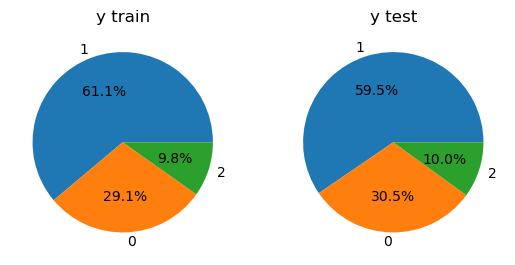

In [64]:
fig, ax = plt.subplots(ncols=2)

y_train.value_counts().plot(kind='pie', ax=ax[0], title='y train', autopct='%1.1f%%')
y_test.value_counts().plot(kind='pie', ax=ax[1], title='y test', autopct='%1.1f%%')
for i in range(2):
    ax[i].set_ylabel("")

In [65]:
# Vectorizing text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [126]:
#create list of model and accuracy dicts
perform_list = [ ]

def run_model(model_name):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier()
    
    elif model_name == 'Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()

    mdl.fit(X_train_vectorized, y_train_encoded)
    y_pred = mdl.predict(X_test_vectorized)
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test_encoded, y_pred), 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test_encoded, y_pred, average='weighted')
    print(f"{model_name}\n{classification_report(y_test_encoded, y_pred)}\n")

    # Add performance parameters to list
    perform_list.append(dict([
    ('Model', model_name),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))]))

In [127]:
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 
               'Support Vector Classifer','Decision Tree Classifier']

for m in model_names:
    run_model(m)

Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.13      0.21       135
           1       0.89      0.81      0.85       412
           2       0.83      0.98      0.90       805

    accuracy                           0.84      1352
   macro avg       0.78      0.64      0.65      1352
weighted avg       0.83      0.84      0.81      1352


Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.85      0.72      0.78       412
           2       0.78      0.96      0.86       805

    accuracy                           0.79      1352
   macro avg       0.54      0.56      0.54      1352
weighted avg       0.72      0.79      0.75      1352


Naive Bayes
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.95      0.58      0.72       412
           2       0.73    

/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Support Vector Classifer
              precision    recall  f1-score   support

           0       0.30      0.04      0.08       135
           1       0.91      0.78      0.84       412
           2       0.81      0.98      0.89       805

    accuracy                           0.83      1352
   macro avg       0.67      0.60      0.60      1352
weighted avg       0.79      0.83      0.79      1352


Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.35      0.36      0.35       135
           1       0.77      0.68      0.72       412
           2       0.82      0.86      0.84       805

    accuracy                           0.76      1352
   macro avg       0.64      0.63      0.64      1352
weighted avg       0.75      0.76      0.75      1352




In [128]:
# Create Dataframe of Model, Accuracy, Precision, Recall, and F1
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance = model_performance.set_index('Model')
model_performance

,Test Accuracy,Precision,Recall,F1
Model,,,,
Logistic Regression,0.84,0.83,0.84,0.81
Random Forest,0.79,0.72,0.79,0.75
Naive Bayes,0.77,0.72,0.77,0.72
Support Vector Classifer,0.83,0.79,0.83,0.79
Decision Tree Classifier,0.76,0.75,0.76,0.75


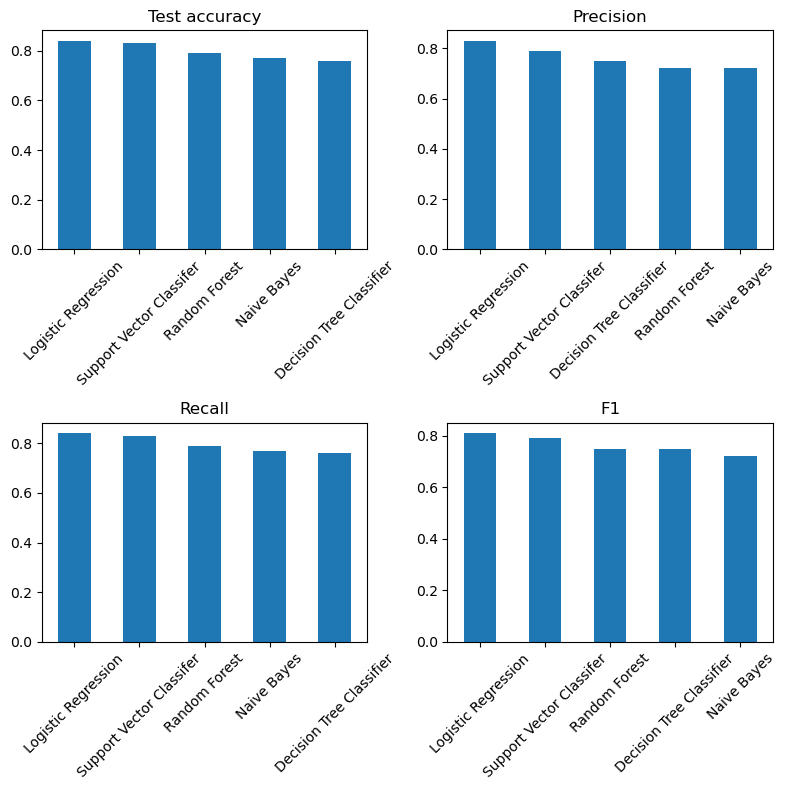

In [129]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

model_performance['Test Accuracy'].sort_values(ascending=False).plot(kind='bar', ax=ax[0,0], rot=45, title="Test accuracy", xlabel="")
model_performance['Precision'].sort_values(ascending=False).plot(kind='bar', ax=ax[0,1], rot=45, title="Precision", xlabel="")
model_performance['Recall'].sort_values(ascending=False).plot(kind='bar', ax=ax[1,0], rot=45, title="Recall", xlabel="")
model_performance['F1'].sort_values(ascending=False).plot(kind='bar', ax=ax[1,1], rot=45, title="F1", xlabel="")
fig.tight_layout()


**Surprisingly "Logistic Regression" have done the best job out of all models. But overall all models have done good job in predicting interview and letter but done terrible job in predicting comment. We will take top 2 models which are Logistic regression and SVC and fine tune them to see if the results get better** 

### Fine tuning of top 2 models

Models in this section:
- Logistic Regression
- Support Vector Classifier

**In the fine tuning process we will use Randomized Search Cross-Validator to find the best hyperparameters possible.**

**We will use Accuracy score to monitor the progress of CV**

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, loguniform
import warnings
import time

In [56]:
def convert_time(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

*Optionally paste n_jobs = -1 in RandomizedSearchCV() function to use all available CPUs in order to speed up the process*

*or define exact number of CPUs* 

In [41]:
# Track runtime
start_t = time.time()

with warnings.catch_warnings():
    # Ignore warnings while running this chunk of code
    warnings.simplefilter("ignore")
    
    # Define hyperparameters grid for Logistic Regression
    param_dist_lr = {
        'C': loguniform(1e-5, 100),  # Continuous loguniform distribution between 0.00001 and 100
        'penalty': ['none', 'l1', 'l2', 'elasticnet'], # Define different penalties
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Define different solvers
        'max_iter': randint(100, 1000) # Define maximum iterations in our LogReg model
    }
    
    # Instantiate Logistic Regression classifier
    lr = LogisticRegression()
    
    # Perform random search
    random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr, n_iter=50, cv=5, scoring='accuracy', random_state=123)
    random_search_lr.fit(X_train_vectorized, y_train_encoded)
    
    # Get best parameters and best scores
    best_params_lr = random_search_lr.best_params_
    best_accuracy_lr = random_search_lr.best_score_
    
    print("Best Parameters for Logistic Regression:", best_params_lr)
    print("Best Accuracy Score for Logistic Regression:", best_accuracy_lr)

end_t = time.time()
runtime = end_t - start_t
print(f"Total runtime: {convert_time(runtime)}")

Best Parameters for Logistic Regression: {'C': 79.23526217687179, 'max_iter': 637, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy Score for Logistic Regression: 0.8670507728005663
Total runtime: 0:08:05


In [73]:
# Define hyperparameters grid for SVC
start_t = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_dist_svc = {
        'C': loguniform(1e-5, 100),  # Continuous uniform distribution between 0.1 and 100
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': randint(1, 10)  # Additional parameter for SVC
    }
    
    # Instantiate SVC classifier
    svc = SVC()
    
    # Perform random search
    random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dist_svc, n_iter=10, cv=5, 
                                           scoring='accuracy', random_state=123, n_jobs=4)
    random_search_svc.fit(X_train_vectorized, y_train_encoded)
    
    # Get best parameters and best scores
    best_params_svc = random_search_svc.best_params_
    best_accuracy_svc = random_search_svc.best_score_
    
    print("Best Parameters for SVC:", best_params_svc)
    print("Best Accuracy Score for SVC:", best_accuracy_svc)

end_t = time.time()
runtime = end_t - start_t
print(f"Total runtime: {convert_time(runtime)}")

Best Parameters for SVC: {'C': 1.2686679007539894, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy Score for SVC: 0.831734496538257
Total runtime: 0:07:13


### Neural Networks for Natural Language Processing

#### Recurrent neural networks (LSTM) for text classification

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [67]:
max_words = 10000 # Max number of words to use in the vocabulary
max_num_words = 0
for val in X_train:
    if len(val.split()) > max_num_words:
        max_num_words = len(val.split())
print(f"Maximum number of words in a text: {max_num_words}")
max_len = int(round(max_num_words/4,2)) # We take the max_num_words / 4 as the max_len becuase of the comp. resources
print(f"Maximum length used: {max_len}")
embedding_dim = 200 # Usually chosen between 50 and 300
num_classes = len(set(ml_df['labels'])) # Number of classes

Maximum number of words in a text: 1766
Maximum length used: 441


In [271]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

In [272]:
X_train_lstm = pad_sequences(sequences, maxlen=max_len)
y_train_lstm = keras.utils.to_categorical(y_train, num_classes)
X_test_lstm = pad_sequences(test_seq, maxlen=max_len)
y_test_lstm = keras.utils.to_categorical(y_test, num_classes)

In [372]:
model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(512, return_sequences=True))

model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [373]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [374]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 363, 200)          2000000   
                                                                 
 lstm_71 (LSTM)              (None, 363, 128)          168448    
                                                                 
 dropout_86 (Dropout)        (None, 363, 128)          0         
                                                                 
 global_max_pooling1d_20 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_87 (Dropout)        (None, 128)               0         
                                                                 
 dense_97 (Dense)            (None, 256)               33024     
                                                     

In [375]:
model.fit(X_train_lstm, y_train_lstm, batch_size=64, 
          epochs=100, callbacks=[early_stop], validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/100
85/85 [==============================] - 49s 545ms/step - loss: 0.6520 - accuracy: 0.7544 - val_loss: 0.4994 - val_accuracy: 0.8454
Epoch 2/100
85/85 [==============================] - 47s 549ms/step - loss: 0.3832 - accuracy: 0.8617 - val_loss: 0.5594 - val_accuracy: 0.8129
Epoch 3/100
85/85 [==============================] - 51s 597ms/step - loss: 0.2669 - accuracy: 0.9072 - val_loss: 0.4368 - val_accuracy: 0.8247
Epoch 4/100
85/85 [==============================] - 47s 553ms/step - loss: 0.1882 - accuracy: 0.9399 - val_loss: 0.4173 - val_accuracy: 0.8291
Epoch 5/100
85/85 [==============================] - 49s 580ms/step - loss: 0.1328 - accuracy: 0.9571 - val_loss: 0.4575 - val_accuracy: 0.8484
Epoch 6/100
85/85 [==============================] - 48s 561ms/step - loss: 0.1574 - accuracy: 0.9497 - val_loss: 0.4765 - val_accuracy: 0.8536
Epoch 7/100
85/85 [==============================] - 48s 570ms/step - loss: 0.1132 - accuracy: 0.9684 - val_loss: 0.4500 - val_accuracy:

<Axes: >

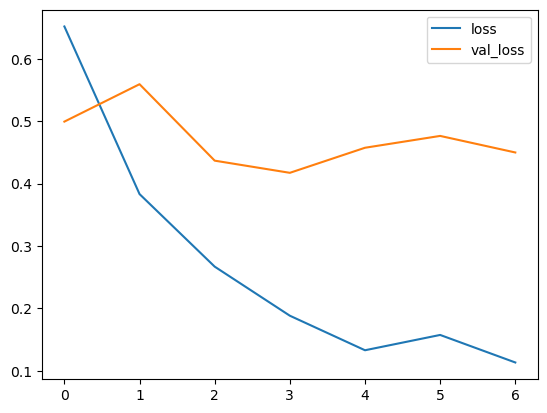

In [377]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot()

In [378]:
preds = np.argmax(model.predict(X_test_lstm), axis=1)

43/43 [==============================] - 4s 91ms/step


In [379]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.83      0.85       412
           1       0.92      0.87      0.89       805
           2       0.39      0.58      0.46       135

    accuracy                           0.83      1352
   macro avg       0.73      0.76      0.74      1352
weighted avg       0.85      0.83      0.84      1352



In [339]:
### SAVING THE MODEL ###

# model.save(filepath="./models/second_lstm_model.h5")
# model.save_weights(filepath="./models/second_lstm_model_weights")

#### Convolutional neural networks (CNN) for text classification

In [333]:
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D

In [392]:
filters = 30
kernel_size = 3

# Before was 16 and 3

## If no improvements recreate the video cnn

In [393]:
cnn = Sequential()

cnn.add(Embedding(max_words, embedding_dim, input_length=max_len))
cnn.add(Dropout(0.5))
cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu'))
cnn.add(MaxPooling1D())
cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu'))
cnn.add(MaxPooling1D())
cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu'))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [394]:
cnn.fit(X_train_lstm, y_train_lstm, batch_size=64, epochs=10, 
        validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stop])

Epoch 1/10
85/85 [==============================] - 13s 132ms/step - loss: 0.5804 - accuracy: 0.7739 - val_loss: 0.4427 - val_accuracy: 0.8247
Epoch 2/10
85/85 [==============================] - 11s 132ms/step - loss: 0.3213 - accuracy: 0.8798 - val_loss: 0.3945 - val_accuracy: 0.8521
Epoch 3/10
85/85 [==============================] - 12s 143ms/step - loss: 0.2057 - accuracy: 0.9351 - val_loss: 0.4409 - val_accuracy: 0.8351
Epoch 4/10
85/85 [==============================] - 12s 144ms/step - loss: 0.1427 - accuracy: 0.9567 - val_loss: 0.5340 - val_accuracy: 0.8203
Epoch 5/10
85/85 [==============================] - 11s 132ms/step - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.5822 - val_accuracy: 0.8195


<Axes: >

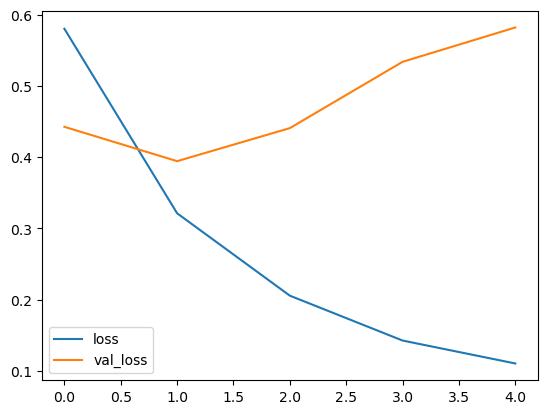

In [395]:
pd.DataFrame(cnn.history.history)[['loss', 'val_loss']].plot()

In [396]:
cnn_preds = np.argmax(cnn.predict(X_test_lstm), axis=1)

43/43 [==============================] - 0s 8ms/step


In [397]:
print(classification_report(y_test, cnn_preds))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       412
           1       0.87      0.96      0.91       805
           2       0.46      0.39      0.42       135

    accuracy                           0.85      1352
   macro avg       0.76      0.71      0.73      1352
weighted avg       0.85      0.85      0.85      1352



In [371]:
### SAVE THE CNN MODEL ###

# cnn.save(filepath="./models/57_cnn_model.keras")
# cnn.save_weights(filepath="./models/57_cnn_model_weights")

## Transformers (LLMs)

In [176]:
ml_df

,text,labels,label_ids
0,zwei jubiläen als stresstest\n\ninterviewlento...,interview,0
1,": ""klimawandel oder klimakrise""\n\n ist nich...",interview,0
2,„kaum eine woche unter 80 arbeitsstunden!“\n\n...,interview,0
3,„check this out! this is paradise!“\n\nder us-...,interview,0
4,„es war eine extreme hochschaubahn“\n\n der ...,interview,0
...,...,...,...
6755,die schulpolitik macht ferien in skandinavien\...,comment,2
6756,"kreative köpfe statt normaldenker, frische neu...",comment,2
6757,"schilling, daphne und lire\n\n daphne? das w...",comment,2
6758,eu-regierungen verlernen demokratie\n\ngetroff...,comment,2


In [177]:
import string

def remove_special_characters(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [178]:
# Apply the function to the 'text' column
ml_df.loc[:,'text'] = ml_df['text'].apply(remove_special_characters)

In [179]:
ml_df

,text,labels,label_ids
0,zwei jubiläen als stresstest\n\ninterviewlento...,interview,0
1,klimawandel oder klimakrise\n\n ist nicht e...,interview,0
2,„kaum eine woche unter 80 arbeitsstunden“\n\nl...,interview,0
3,„check this out this is paradise“\n\nder usame...,interview,0
4,„es war eine extreme hochschaubahn“\n\n der ...,interview,0
...,...,...,...
6755,die schulpolitik macht ferien in skandinavien\...,comment,2
6756,kreative köpfe statt normaldenker frische neug...,comment,2
6757,schilling daphne und lire\n\n daphne das war...,comment,2
6758,euregierungen verlernen demokratie\n\ngetroffe...,comment,2


In [180]:
from transformers import AutoTokenizer

In [181]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

In [182]:
seqlen = ml_df['text'].apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

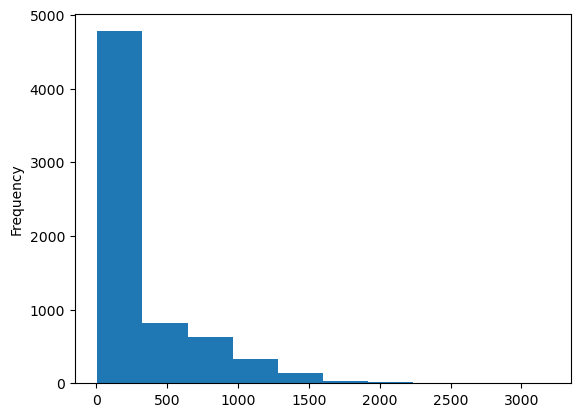

In [183]:
seqlen.plot(kind="hist")

To speed up the process I'll use max_len predefined as seq_len. Normally would use seq_len = ca. 1500

In [184]:
seq_len = max_len

In [185]:
tokens = tokenizer.encode_plus(ml_df.loc[1,"text"], max_length=seq_len, truncation=True, padding="max_length",
                              add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True,
                              return_tensors="tf")

In [186]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 441), dtype=int32, numpy=
array([[    3,   714,  3988, 16922,   309,   714,  3988, 10184,   127,
          149, 15601,  7704,   789,  4441,   232,   142, 13049,   747,
          592,     7,  6247,  3998, 10070,  1195,   144,    30,  2037,
        26911,  5288,  7852,  1900,   444,  4762,  7654, 26897, 12412,
         2636,  8042,  1812,  3376,   114,   312,   282,    42, 13558,
          160,   380,   266,  2324,   230, 13883,    57, 23000,    42,
         6699,  4300,  1885,    39,  4905, 26898,  1760,  6488,   262,
         5128,  2860,  1234, 12046,  1762, 21004,  2455, 14226,   232,
         2099,  3291,   850,  4543,   789,  4441,  1113,  5367,   127,
          961,   127,    93,  1717,   731,   379,    21,  3861,  1627,
         3522,  1136,  3988,  9671,    39, 20551,   188, 10330,   309,
          188, 11084, 19884, 19546,     2,  3146,   155,  4493,  9561,
        26897, 23888,   155, 13989, 10133,  4731,    27,   221,  2776,
            7, 

In [187]:
Xids = np.zeros((len(ml_df), seq_len))
Xmask = np.zeros((len(ml_df), seq_len))

In [188]:
for i, seq in enumerate(ml_df['text']):
    tokens = tokenizer.encode_plus(seq, max_length=seq_len, truncation=True, padding="max_length",
                              add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True,
                              return_tensors="tf")
    Xids[i,:], Xmask[i,:] = tokens['input_ids'], tokens['attention_mask']

In [189]:
Xids

array([[3.0000e+00, 3.8200e+02, 2.6618e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 7.1400e+02, 3.9880e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 2.0000e+00, 2.8960e+03, ..., 9.3700e+02, 6.8000e+01,
        4.0000e+00],
       ...,
       [3.0000e+00, 2.0500e+02, 3.1800e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 4.5400e+02, 2.4010e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 4.1540e+03, 1.4123e+04, ..., 2.8700e+02, 1.3040e+03,
        4.0000e+00]])

In [190]:
arr = ml_df['label_ids'].values
labels = np.zeros((arr.size, arr.max()+1))

In [191]:
labels[np.arange(arr.size),arr] = 1

In [192]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [193]:
with open('xids.npy', 'wb') as f:
    np.save(f, Xids)

with open('xmask.npy', 'wb') as f:
    np.save(f, Xmask)

with open('labels.npy', 'wb') as f:
    np.save(f, labels)

del Xids, Xmask, labels

In [194]:
with open('xids.npy', 'rb') as f:
    Xids = np.load(f)

with open('xmask.npy', 'rb') as f:
    Xmask = np.load(f)

with open('labels.npy', 'rb') as f:
    labels = np.load(f)

In [195]:
Xids, Xmask, labels

(array([[3.0000e+00, 3.8200e+02, 2.6618e+04, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0000e+00, 7.1400e+02, 3.9880e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0000e+00, 2.0000e+00, 2.8960e+03, ..., 9.3700e+02, 6.8000e+01,
         4.0000e+00],
        ...,
        [3.0000e+00, 2.0500e+02, 3.1800e+02, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0000e+00, 4.5400e+02, 2.4010e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0000e+00, 4.1540e+03, 1.4123e+04, ..., 2.8700e+02, 1.3040e+03,
         4.0000e+00]]),
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

In [196]:
import tensorflow as tf

In [197]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [198]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(441,), dtype=float64, numpy=
array([3.0000e+00, 3.8200e+02, 2.6618e+04, 1.2600e+02, 2.6923e+04,
       7.0000e+00, 1.5300e+02, 1.4565e+04, 1.2490e+03, 2.8400e+02,
       2.5560e+03, 4.8920e+03, 2.9410e+03, 1.4481e+04, 2.6902e+04,
       4.2000e+01, 3.1940e+03, 5.8270e+03, 8.8440e+03, 1.4000e+01,
       5.7260e+03, 5.1680e+03, 2.6903e+04, 8.6530e+03, 4.5200e+02,
       1.0840e+03, 1.4400e+02, 1.4800e+02, 4.8270e+03, 2.0400e+02,
       3.9000e+01, 5.2300e+02, 9.9850e+03, 6.9600e+02, 5.1000e+01,
       4.2000e+01, 1.5500e+02, 1.9584e+04, 1.2654e+04, 2.0500e+02,
       9.7880e+03, 1.7625e+04, 4.2000e+01, 2.4204e+04, 3.8530e+03,
       5.7900e+02, 5.0000e+01, 3.0000e+01, 8.1000e+01, 1.6680e+03,
       5.7260e+03, 5.1680e+03, 2.6903e+04, 8.6530e+03, 4.5200e+02,
       1.8000e+02, 2.0371e+04, 1.4400e+02, 2.0400e+02, 3.9000e+01,
       5.2300e+02, 9.9850e+03, 6.9600e+02, 5.1000e+01, 3.0000e+01,
       5.6900e+02, 4.0530e+03, 2.0010e+03, 8.0000e+00, 1.6200e+02,
       2.0000

In [199]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [200]:
dataset = dataset.map(map_func)

In [201]:
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(441,), dtype=float64, numpy=
array([3.0000e+00, 3.8200e+02, 2.6618e+04, 1.2600e+02, 2.6923e+04,
       7.0000e+00, 1.5300e+02, 1.4565e+04, 1.2490e+03, 2.8400e+02,
       2.5560e+03, 4.8920e+03, 2.9410e+03, 1.4481e+04, 2.6902e+04,
       4.2000e+01, 3.1940e+03, 5.8270e+03, 8.8440e+03, 1.4000e+01,
       5.7260e+03, 5.1680e+03, 2.6903e+04, 8.6530e+03, 4.5200e+02,
       1.0840e+03, 1.4400e+02, 1.4800e+02, 4.8270e+03, 2.0400e+02,
       3.9000e+01, 5.2300e+02, 9.9850e+03, 6.9600e+02, 5.1000e+01,
       4.2000e+01, 1.5500e+02, 1.9584e+04, 1.2654e+04, 2.0500e+02,
       9.7880e+03, 1.7625e+04, 4.2000e+01, 2.4204e+04, 3.8530e+03,
       5.7900e+02, 5.0000e+01, 3.0000e+01, 8.1000e+01, 1.6680e+03,
       5.7260e+03, 5.1680e+03, 2.6903e+04, 8.6530e+03, 4.5200e+02,
       1.8000e+02, 2.0371e+04, 1.4400e+02, 2.0400e+02, 3.9000e+01,
       5.2300e+02, 9.9850e+03, 6.9600e+02, 5.1000e+01, 3.0000e+01,
       5.6900e+02, 4.0530e+03, 2.0010e+03, 8.0000e+00, 1.6200e+02,

In [202]:
dataset = dataset.shuffle(100000).batch(32)

In [203]:
ds_len = len(list(dataset))

In [204]:
ds_len

212

In [205]:
split = .8

train = dataset.take(round(ds_len*split))
test = dataset.skip(round(ds_len*split))

del dataset

In [206]:
from transformers import TFAutoModel

In [207]:
bert = TFAutoModel.from_pretrained('bert-base-german-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [208]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
X = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=X)

model.layers[2].trainable = False #Freeze bert model

In [209]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 441)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 441)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1090813   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 441, 7                                     

In [210]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [211]:
history = model.fit(
    train,
    validation_data=test,
    epochs = 3
)

Epoch 1/3
  6/170 [>.............................] - ETA: 1:01:28 - loss: 1.7785 - accuracy: 0.6667

KeyboardInterrupt: 